# GRADCAM

Let's start with a pretrained VGG model

In [0]:
# import libraries and helper functions for VGG model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
# load VGG
model = VGG16(weights="imagenet")

In [64]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [65]:
# Load Image
! wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
from PIL import Image 
im = Image.open("16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg").convert('RGB')

--2019-10-03 05:06:54--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.246.83, 190.93.247.83, 190.93.245.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.246.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.1’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.005s  

2019-10-03 05:06:54 (10.9 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.1’ saved [58670/58670]



(692, 695, 3)


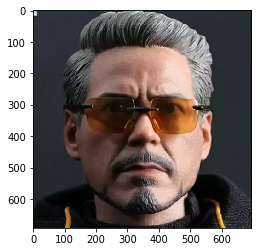

In [66]:
# convert to numpy array
tony = np.asarray(im)
print(tony.shape)
plt.imshow(tony);

In [0]:
'''
1. Rescale image to 224x224x3
2. Use expand_dims to convert image to a batch of size 1
3. Preprocesing normalizes our input image by subtracting mean RGB values
'''
tony = cv2.resize(tony, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tony)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

## Part 1
First we will visualise how the GradCAM activations look like for the last convolution layer "block5_conv3" and then we will visualize the activations for the layer before and after to observe the difference   

In [0]:
def visualise_grads(actual_img, scaled_image, layer, class_idx=None):
  '''
  img: input image for which to visualize grad cam activations
  layer: for which layer you want to visualise activations
  class_id: for which class to visualize activations
  Steps:
  1. We get the predictions for the image
  2. We take the topmost class index
  3. Take output from the final convolutional layer
  4. Compute the gradient of the class output value with respect to the feature map
  5. Pool the gradients over all the axies leaving out the channel dimension
  6. Weigh the output feature map with the computed gradient values
  7. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
  8. Normalize the heat map to make the values between 0 and 1
  '''
  preds = model.predict(scaled_image)
  if class_idx:
    print("Class Id provided explicitly")
    print("class_id: ", class_idx)
    class_output = model.output[:, class_idx]
  else:
    class_idx = np.argmax(preds[0])
    print("class_id: ", class_idx)
    class_output = model.output[:, class_idx]
  
  last_conv_layer = model.get_layer(layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([scaled_image])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  print(conv_layer_output_value.shape)
  print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (actual_img.shape[1], actual_img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(actual_img, 0.5, heatmap, 0.5, 0)
  # plt.imshow(tony)
  plt.imshow(superimposed_img)


class_id:  837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


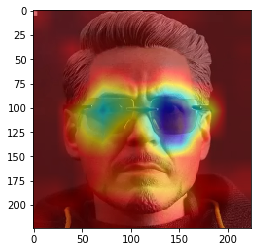

In [69]:
# GradCAM Visualization if we use last convolution layer
visualise_grads(tony, x, "block5_conv3")

class_id:  837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


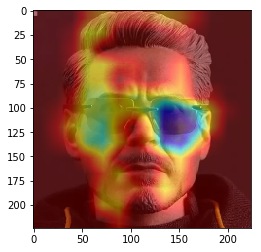

In [70]:
# GradCAM Visualization if we use second last convolution layer
visualise_grads(tony, x, "block5_conv2")

class_id:  837
(?, 7, 7, 512)
(512,)
(7, 7, 512)
(7, 7)


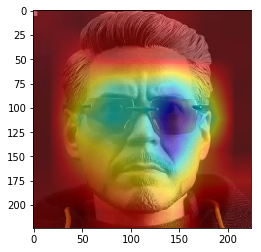

In [71]:
# GradCAM Visualization if we use layer after last convolution layer
visualise_grads(tony, x, "block5_pool")

## Part 2
We will find sunglasses using GradCAM. 
Class id for sunglasses is 837 which I got from this link: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a.
And our model is predicting this class only. However, we will still provide the class id explicitly as per the assignment

Class Id provided explicitly
class_id:  837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


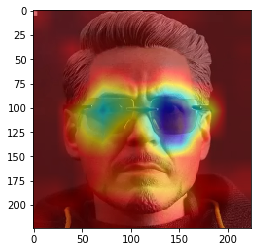

In [72]:
visualise_grads(tony, x, "block5_conv3", 837)